In [177]:
import pandas as pd
import spacy
from spacy.matcher import Matcher
from spacy.tokens import Span
import networkx as nx

import glob
import string

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [59]:
tweet_files = glob.glob('../Data/Tweets_scraped_2000_*.csv')
news_files = glob.glob('../Data/corona_news_scraped_on_2*.csv')

In [74]:
print('\n'.join('Tweet File {}: {}'.format(*k) for k in enumerate(tweet_files)))

Tweet File 0: ../Data\Tweets_scraped_2000_24th_CORONA_COVID.csv
Tweet File 1: ../Data\Tweets_scraped_2000_26th_CORONA_COVID.csv
Tweet File 2: ../Data\Tweets_scraped_2000_29th_CORONA_COVID.csv


In [75]:
print('\n'.join('News File {}: {}'.format(*k) for k in enumerate(news_files)))

News File 0: ../Data\corona_news_scraped_on_24th_march.csv
News File 1: ../Data\corona_news_scraped_on_26th_march.csv
News File 2: ../Data\corona_news_scraped_on_29th_march.csv


In [76]:
all_news = pd.concat([pd.read_csv(f) for f in news_files],ignore_index =True)
all_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658 entries, 0 to 657
Data columns (total 2 columns):
datetime    658 non-null object
text        658 non-null object
dtypes: object(2)
memory usage: 10.4+ KB


In [77]:
all_tweets = pd.concat([pd.read_csv(f) for f in tweet_files],ignore_index =True)
all_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 5 columns):
geo               6 non-null object
tweet             6000 non-null object
user_handle       6000 non-null object
location          4370 non-null object
cleaned_tweets    5995 non-null object
dtypes: object(5)
memory usage: 234.5+ KB


In [78]:
all_tweets.drop(columns=['geo','tweet','user_handle','location'],axis = 1,inplace=True)
all_tweets.rename(columns={'cleaned_tweets':'text'},inplace=True)
all_tweets.head()

,text
0,punjab cm captain amarinder singh has sought ...
1,excited to announce that we have launched cov...
2,this corona is going to teach us a lot of thi...
3,public health expes including dr anthony fauc...
4,a spencer thank you everyone for your incredi...


In [79]:
documents = pd.DataFrame()
documents['text'] = pd.concat([all_news.text,all_tweets.text],axis =0 ,ignore_index=True)
documents.head()

,text
0,"2 new positive cases reported, positive cases ..."
1,"23-year old, with the recent travel history to..."
2,Coronavirus lockdown in Maharashtra: What's ex...
3,Visual from Srinagar as the complete lockdown ...
4,QuoteThe total number of positive Coronavirus...


In [80]:
documents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6658 entries, 0 to 6657
Data columns (total 1 columns):
text    6653 non-null object
dtypes: object(1)
memory usage: 52.1+ KB


In [81]:
documents = documents.sample(frac=1).reset_index(drop=True)

In [84]:
documents.head()

,text
0,turned into turned into because of this COVID
1,i accept the stayathomechallenge from ministe...
2,no one will starve during this lockdown covid...
3,Currently in G ovt although voted out profite...
4,Another death of 70 year old man in Gujarat. T...


In [85]:
nlp = spacy.load('en_core_web_sm')

### Cleaning Data for NLP

In [86]:
import re
# Remove HTML Tags
def remove_html(text):
    soup = BeautifulSoup(text,'lxml')
    html_free_text = soup.get_text()
    return html_free_text

# Remove Punctuations
def punctuation_remover(text):
    punctuation_free_text = " ".join([word for word in text if word \
                                    not in string.punctuation])
    return punctuation_free_text


# Stop Word Removal
cached_stop_words = stopwords.words('english') # Provides 70 X Speedup
def stop_words_remover(text):
#     text = text.lower().split()
    words = [word for word in text if \
             word not in cached_stop_words]
    return words

# Convert to lower case
def convert_to_lowercase(tokens):
    low = []
    for tok in tokens:
        low.append(tok.lower().strip())
    return low

# Lemmatization
def lemmatize_words(text):
    words = nlp(str(text))
    return [word.lemma_ for word in words if word.lemma_ != '-PRON-']  

def replace_urls(tokens):
    re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", tokens)
    return tokens


def remove_short_strings(text, length):
    array = []
    for word in text:
        if len(word) > length:
            array.append(word)
    return array

In [87]:
tokenized_documents = documents.copy()
tokenized_documents['text'] = tokenized_documents.text.astype(str)

In [88]:
def clean_text_for_tasks(text, for_pos_tagging = False):
    cleaned_text = remove_html(text)
    cleaned_text = replace_urls(cleaned_text)
    cleaned_text = word_tokenize(cleaned_text)
   
    
    if for_pos_tagging is False:
        cleaned_text = convert_to_lowercase(cleaned_text)
        cleaned_text = stop_words_remover(cleaned_text)
        cleaned_text = lemmatize_words(cleaned_text)
    cleaned_text = remove_short_strings(cleaned_text,2)
    cleaned_text = punctuation_remover(cleaned_text)
    
    return cleaned_text

In [89]:
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()
# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True)

tokenized_documents['cleaned_text'] = tokenized_documents.text.progress_apply(clean_text_for_tasks)
# tokenized_documents['cleaned_text'] = tokenized_documents.text.parallel_apply(clean_text_for_tasks,axis = 1 )

In [90]:
tokenized_documents.head()

,text,cleaned_text
0,turned into turned into because of this COVID,turn turn covid
1,i accept the stayathomechallenge from ministe...,accept stayathomechallenge minister nominate
2,no one will starve during this lockdown covid...,one starve lockdown covid kerala take extensiv...
3,Currently in G ovt although voted out profite...,currently ovt although vote profiteer business...
4,Another death of 70 year old man in Gujarat. T...,another death year old man gujarat total death...


### Using Linguistic Features such as Named Entity Recognition and Parts-of-Speech

We will use these features to gain more insights into the most talked about entities. Which will allow us 
to further explore into those topics.

In [91]:
tokenized_documents[200:300].head(10)

,text,cleaned_text
200,it is with great regret that eshre today anno...,great regret eshre today announce cancellation...
201,FACT Being able to hold your breath for secon...,fact able hold breath second without cough fee...
202,simple ways of taking care of each other durin...,simple way take care coronaviruslockdown infor...
203,eu hand washing is key to prevent fuher sprea...,hand washing key prevent fuher spread covid kn...
204,Pets are not a source of coronavirus Vet and ...,pet source coronavirus vet founder pup aid mar...
205,breaking uk orders everyone in uk to stay at ...,break order everyone stay home face police act...
206,it is now necessary to shutdown all but essen...,necessary shutdown essential service delay cos...
207,cheung Mapping the COVID outbreak Confirmed c...,cheung mapping covid outbreak confirm case cor...
208,free accommodation for hkl healthcare workers...,free accommodation hkl healthcare worker fight...
209,lockdown is almost here as the clock ticks dow...,lockdown almost clock tick face fear anxiety f...


In [92]:
from spacy import displacy

doc_1 = nlp(tokenized_documents.iloc[207].text)
displacy.render(doc_1, style="ent")

In [106]:
doc_1 = nlp(tokenized_documents.iloc[400].text)
displacy.render(doc_1, style="ent")

#### We can see that spacy does not recognize the Corona Virus 

In [107]:
# sample_texts = tokenized_documents[200:300].text.apply(lambda x : clean_text_for_tasks(x ,for_pos_tagging=True))
# sample_texts = tokenized_documents[200:300].cleaned_text
training_sample_data = tokenized_documents.sample(10,random_state=10)
for  text in training_sample_data.text:
    test_doc = nlp(text)
    displacy.render(test_doc, style="ent")
    print('---------')

---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


#### We will retrain the model to detect few of these entities

In [108]:
#To-DO

In [109]:
# from spacy.symbols import nsubj, VERB,NORP, NOUN, PRON

# verbs = set()
# for possible_subject in test_doc:
#     if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
#         verbs.add(possible_subject.head)
# print(verbs)

In [110]:
# from spacy import displacy
# displacy.render(test_doc, style="ent")

### Find POS tags for each document like NOUN and PROPN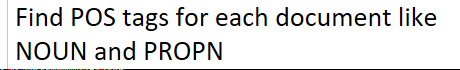

In [111]:
docs_for_pos = tokenized_documents.copy()
docs_for_pos['cleaned_for_pos_tagging'] = tokenized_documents.text.apply(lambda x : clean_text_for_tasks(x ,for_pos_tagging=True))   

In [112]:
def get_pos_tags():

    INTERTESTED_POS_TAGS = ['NOUN' , 'PROPN' ]
    tags = []
    for index,sentence in tqdm_notebook(docs_for_pos.iterrows()):
        pos= {}
        tokenized = nlp(sentence.cleaned_for_pos_tagging)
    #     tokenized = nlp(text)
        for token in tokenized:
            if token.pos_ in INTERTESTED_POS_TAGS:
    #                 print(token.text,token.pos_)
                pos['word'] = token.text
                pos['pos_tag'] = token.pos_
                tags.append(pos)
    return tags

In [113]:
# from joblib import Parallel, delayed
# tags = Parallel(n_jobs=8,backend='multiprocessing')(
#             delayed(get_pos_tags())
# #         )
# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True)

# tags = docs_for_pos.parallel_apply(get_pos_tags,axis =1 )
tags = get_pos_tags()

In [114]:
tags_df = pd.DataFrame(tags)
tags_df.head()

,pos_tag,word
0,NOUN,COVID
1,NOUN,minister
2,NOUN,minister
3,NOUN,measures
4,NOUN,measures


In [115]:
tags_size = tags_df.groupby(['pos_tag', 'word']).size()

In [116]:
tags_noun = tags_df.loc[tags_df.pos_tag == 'NOUN']
tags_noun.head()

,pos_tag,word
0,NOUN,COVID
1,NOUN,minister
2,NOUN,minister
3,NOUN,measures
4,NOUN,measures


In [120]:
from pandas.core.common import flatten

all_noun_words =list(flatten(tags_df.word.values))

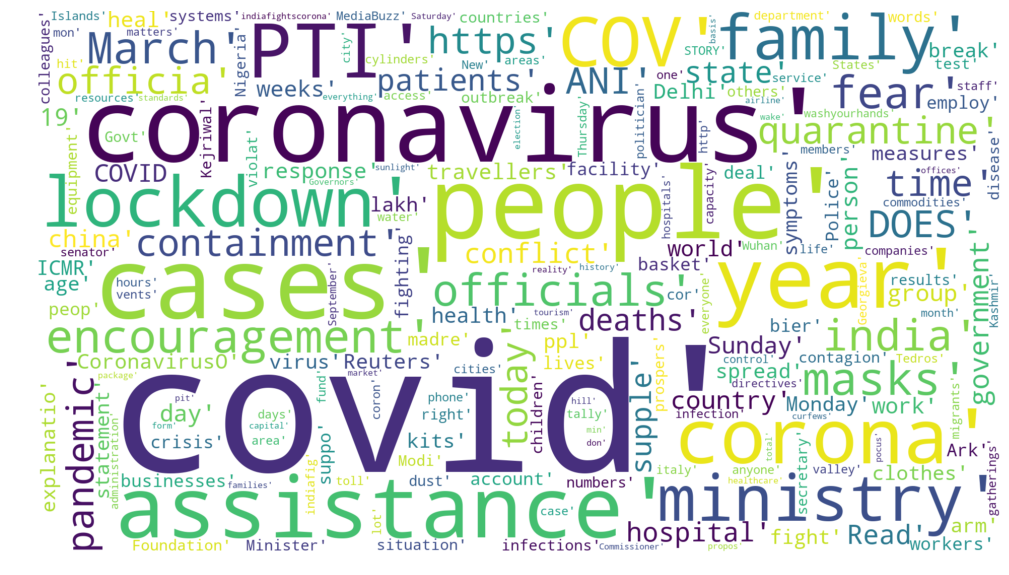

In [121]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

def generate_word_cloud(words):
    wordcloud = WordCloud(background_color = 'white',collocations=False,width=1920, height=1080).generate(str(words))
    plt.figure(figsize= (20,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

generate_word_cloud(all_noun_words)  

In [122]:
from collections import Counter

noun_counts = Counter(tags_df.word)

In [123]:
print(noun_counts.most_common(30))

[('covid', 1987), ('COVID', 1067), ('coronavirus', 512), ('cases', 501), ('people', 488), ('assistance', 467), ('year', 459), ('PTI', 357), ('corona', 332), ('lockdown', 306), ('family', 279), ('encouragement', 268), ('fear', 248), ('quarantine', 239), ('pandemic', 237), ('DOES', 236), ('ministry', 235), ('containment', 234), ('time', 230), ('https', 228), ('ANI', 227), ('officia', 225), ('today', 213), ('patients', 204), ('officials', 201), ('COV', 188), ('March', 182), ('deaths', 181), ('state', 173), ('supple', 172)]


In [124]:
most_common_nouns = noun_counts.most_common(40)
for i in range(3):
    most_common_nouns.pop(0)

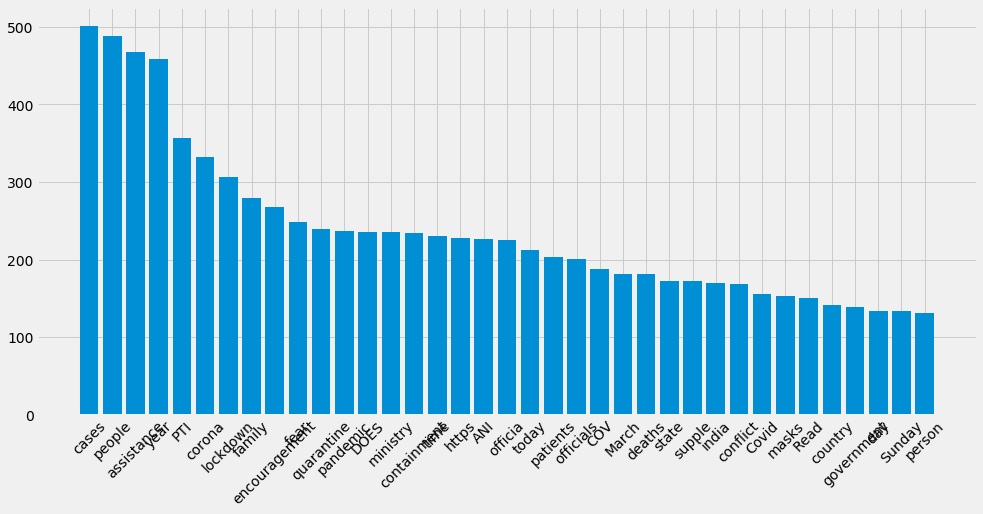

In [125]:
plt.style.use('fivethirtyeight')
# plt.title('Most Commonly Used NOUNs')
plt.figure(figsize=(15,7))
plt.xticks(rotation='45')
plt.bar(*zip(*most_common_nouns))
plt.show()


### Now, let us find the most common occuring Entities

In [126]:
def get_entity_tags():

    INTERTESTED_ENTITY_TAGS = ['NORP' , 'GPE' ,'ORG', 'PRODUCT', 'LOC', 'PERSON']
    tags = []
    for index,sentence in tqdm_notebook(docs_for_pos.iterrows()):
        entity= {}
        tokenized = nlp(sentence.cleaned_for_pos_tagging)
        for ent in tokenized.ents:
            if ent.label_ in INTERTESTED_ENTITY_TAGS:
                entity['word'] = ent.text
                entity['entity_tag'] = ent.label_
                tags.append(entity)
    return tags

In [127]:
entities = get_entity_tags()

In [35]:
# entities

In [36]:
entities_df = pd.DataFrame(entities)

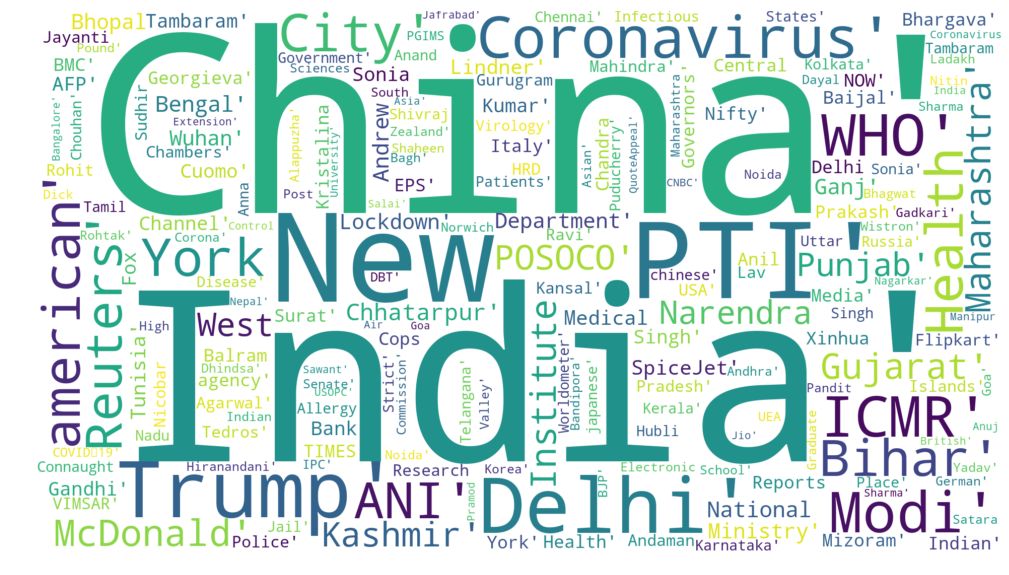

In [57]:
all_entities =list(flatten(entities_df.word.values))
generate_word_cloud(all_entities)  

In [128]:
entity_counts = Counter(entities_df.word)

In [129]:
entity_counts.most_common(30)

[('India', 55),
 ('China', 52),
 ('PTI', 31),
 ('Trump', 21),
 ('Delhi', 20),
 ('Coronavirus', 20),
 ('WHO', 20),
 ('ICMR', 19),
 ('New York City', 16),
 ('Reuters', 15),
 ('Bihar', 15),
 ('McDonald', 14),
 ('Gujarat', 13),
 ('Maharashtra', 13),
 ('american', 13),
 ('ANI', 12),
 ('Kashmir', 12),
 ('POSOCO', 12),
 ('Punjab', 11),
 ('Narendra Modi', 11),
 ('Chhatarpur', 11),
 ('Andrew Ganj', 10),
 ('Wuhan', 9),
 ('Bhopal Lockdown', 9),
 ('Modi', 8),
 ('Tunisia', 8),
 ('SpiceJet', 8),
 ('Lindner', 8),
 ('china', 8),
 ('AFP', 7)]

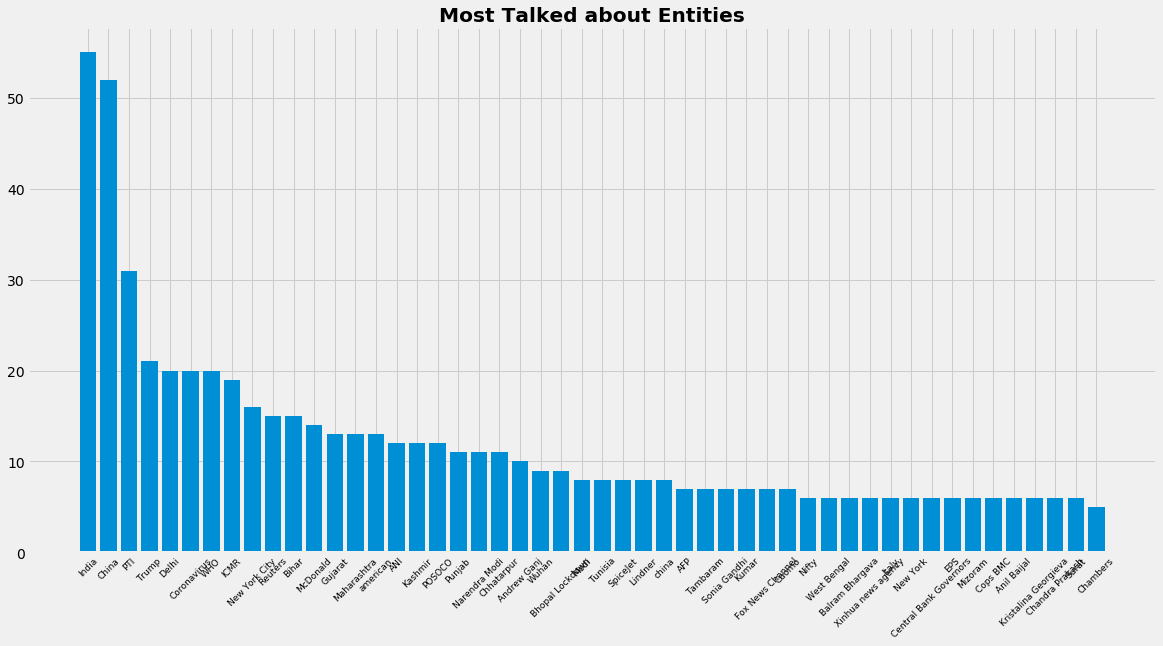

In [132]:
plt.figure(figsize=(18,9))
plt.xticks(rotation='45',fontsize = 9)
plt.bar(*zip(*entity_counts.most_common(50)))
plt.title(label = 'Most Talked about Entities',fontweight = 'bold')
plt.show()


#### Let's find some documents swith the Top enities that we found above

In [133]:
entity_filtered_docs = docs_for_pos[(docs_for_pos.cleaned_for_pos_tagging.str.contains('India')) 
                                    | ( docs_for_pos.cleaned_for_pos_tagging.str.contains('WHO'))
                                    | ( docs_for_pos.cleaned_for_pos_tagging.str.contains('ICMR'))
                                    | ( docs_for_pos.cleaned_for_pos_tagging.str.contains('Maharastra'))]

In [134]:
entity_filtered_docs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 8 to 6647
Data columns (total 3 columns):
text                       219 non-null object
cleaned_text               219 non-null object
cleaned_for_pos_tagging    219 non-null object
dtypes: object(3)
memory usage: 6.8+ KB


In [137]:
for  text in entity_filtered_docs.sample(10).text:
    test_doc = nlp(text)
    displacy.render(test_doc, style="ent")
    print('---------')

---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


### Entity Relations using Knowledge Graph

We have to do some dependency parsing on the texts to find the Subjects and objects and find the ROOT word i.e. the dependency between them

In [143]:
# https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/?utm_source=blog&utm_medium=introduction-information-extraction-python-spacy

def get_entity_pairs(text):

    entity_1 = ''
    entity_2 = ''

    previous_dependency = ''
    previous_text = ''

    prefix = ''
    modifier = ''

    for token in nlp(text):
        if token.dep_ != 'punct':
            if token.dep_ == 'compound':
                prefix = previous_text + " "+ token.text

         # check: token is a modifier or not
        if token.dep_.endswith("mod") == True:
            modifier = token.text
        # if the previous word was also a 'compound' then add the current word to it
            if previous_dependency == "compound":
                  modifier = previous_text + " "+ token.text

      ## chunk 3
        if token.dep_.find("subj") == True:
            entity_1 = modifier +" "+ prefix + " "+ token.text
            prefix = ""
            modifier = ""
            previous_text = ""
            previous_dependency = ""      

      ## chunk 4
        if token.dep_.find("obj") == True:
            entity_2 = modifier +" "+ prefix +" "+ token.text

      ## chunk 5  
      # update variables
        prv_tok_dep = token.dep_
        prv_tok_text = token.text
  #############################################################
    return [entity_1.strip(), entity_2.strip()]

In [198]:
entity_pairs = [get_entity_pairs(text) for text in tqdm_notebook(entity_filtered_docs.text)]

In [199]:
entity_pairs[5:25]

[['ADANI FOUNDATION', 'Rs COVID'],
 ['ADANI FOUNDATION', 'Rs COVID'],
 ['where  head', 'press C'],
 ['277  wellness Indians', 'already  centre'],
 ['', 'more  COVID details'],
 ['PM Modi', 'several  Lakshman days'],
 ['only  which', 'only  people'],
 ['three  Services who', 'March'],
 ['ADANI FOUNDATION', 'Rs COVID'],
 ['ADANI FOUNDATION', 'Rs COVID'],
 ['ADANI FOUNDATION', 'Rs COVID'],
 ['human  Masks t', 'human  Masks don'],
 ['human  Masks t', 'human  Masks don'],
 ['current  lockdown clients', 'PMS account'],
 ['account', 'legal  demand'],
 ['Indian Army', 'territorial  Command test'],
 ['PM Modi', 'that'],
 ['Modi', 'workers'],
 ['three  Services who', 'March'],
 ['Health  Kumar Singh', 'two  infants']]

In [200]:
def get_relation(text):
    
    doc = nlp(text)
    matcher =  Matcher(nlp.vocab)
    
    pattern = [
                {'DEP' : 'ROOT'},
                {'DEP' : 'prep', 'OP': '?'},
                {'DEP' : 'agent','OP': '?'},
                {'POS' : 'ADJ','OP' : '?' }
              ]
    
    matcher.add('matching_1', None , pattern)
    matches = matcher(doc)
    k = len(matches) - 1
    
    span = doc[matches[k][1]:matches[k][2]]
    
    return(span.text)

In [202]:
entity_relations = [get_relation(text) for text in tqdm_notebook(entity_filtered_docs.text)]

In [203]:
Counter(entity_relations).most_common(10)

[('adani', 32),
 ('evidence of', 22),
 ('tested positive', 18),
 ('said', 7),
 ('Read', 6),
 ('is', 5),
 ('withheld in', 4),
 ('has', 4),
 ('"', 3),
 ('told', 3)]

In [231]:
def combine_entities_and_relations(entity_pairs , entity_relations):   
    entity_subjects = [i[0] for i in entity_pairs ]
    entity_objects  = [i[1] for i in entity_pairs ]

    entities_and_relations_df = pd.DataFrame({'subject': entity_subjects,
                                              'object' : entity_objects,
                                              'relation': entity_relations
                                             })

    entities_and_relations_df.drop_duplicates(subset=None, keep='first', inplace=True)
    
    return entities_and_relations_df

In [232]:
entities_and_relations_df = combine_entities_and_relations(entity_pairs , entity_relations)
entities_and_relations_df.relation.value_counts()

said               5
Read               5
is                 5
has                3
"                  3
told               2
s                  2
Ministry           2
confirmed          2
says               2
constitutes        1
records            1
realise            1
delivered          1
look at            1
is important       1
tests positive     1
rises to           1
paid               1
spend              1
were among         1
included under     1
were               1
screened           1
cured              1
sought             1
is unique          1
soars to           1
reduce overall     1
’re                1
                  ..
tested positive    1
video              1
The                1
closed             1
offer free         1
set                1
made               1
shut               1
wrote to           1
stands with        1
asked              1
said of            1
put under          1
paicipating in     1
suspends           1
Ghebreyesus        1
urges        

### Computing the Entity relation for the entire corpus

In [235]:
entity_pairs_for_all_data = [get_entity_pairs(text) for text in tqdm_notebook(docs_for_pos.text)]

In [236]:
entity_relations_for_all_data = [get_relation(text) for text in tqdm_notebook(docs_for_pos.text)]

In [238]:
entities_and_relations_all = combine_entities_and_relations(entity_pairs_for_all_data , entity_relations_for_all_data)
entities_and_relations_all.relation.value_counts()

is                           213
are                           75
s                             71
said                          45
have                          41
let                           39
says                          37
help                          33
be                            31
has                           29
know                          23
announced                     20
was                           20
think                         19
stay                          18
reports                       18
covid                         17
tested positive               17
say                           17
take                          16
need                          16
launched                      16
Read                          15
confirmed                     14
m                             14
thank                         13
had                           13
"                             13
coronavirus                   12
sending                       12
          

In [280]:
def compute_and_plot_network(entities_and_relations_df , relation_text ):   
    network = nx.from_pandas_edgelist(entities_and_relations_df.loc[entities_and_relations_df.relation == relation_text],
                                      source= 'subject',
                                      target= 'object',
                                      edge_attr=True,
                                      create_using=nx.MultiDiGraph()
                                     )

    # Plot the network
    plt.figure(figsize=(14,6))
    pos = nx.spring_layout(network)
    nx.draw(network, 
            with_labels=True,
            arrows = True,
            font_size = 9,
            node_color='skyblue',
            edge_cmap=plt.cm.Blues,
            pos = pos,
           )
#     labels=nx.draw_networkx_labels(network,pos=pos,font_size=7)
    plt.show()

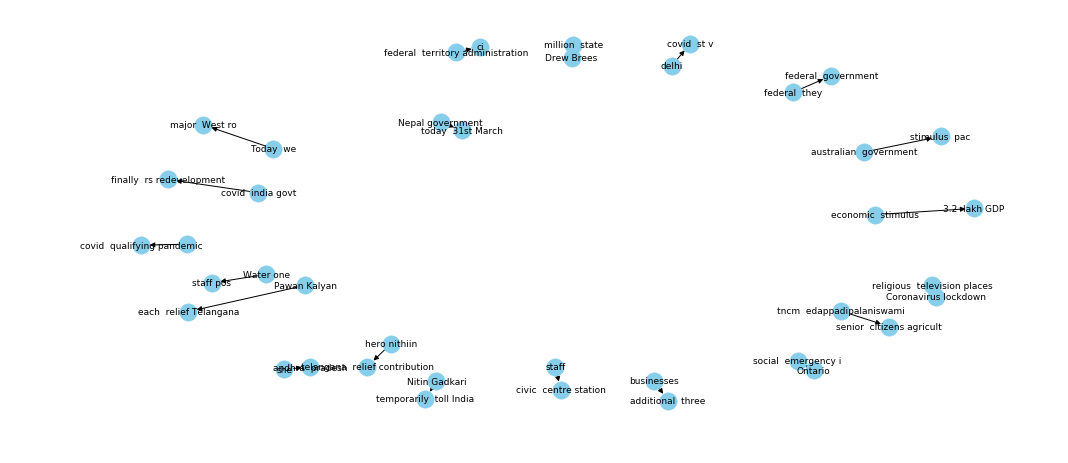

In [281]:
compute_and_plot_network(entities_and_relations_all,'announced')

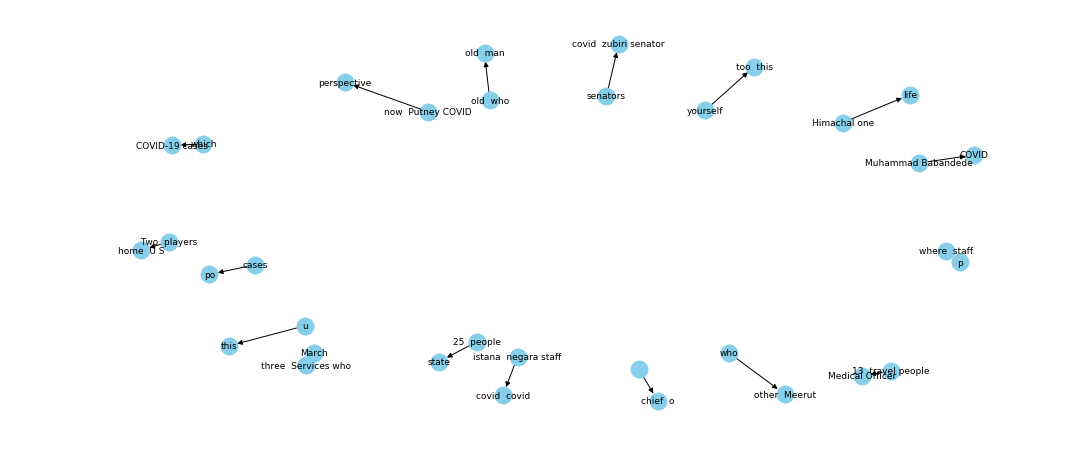

In [277]:
compute_and_plot_network(entities_and_relations_all,'tested positive')

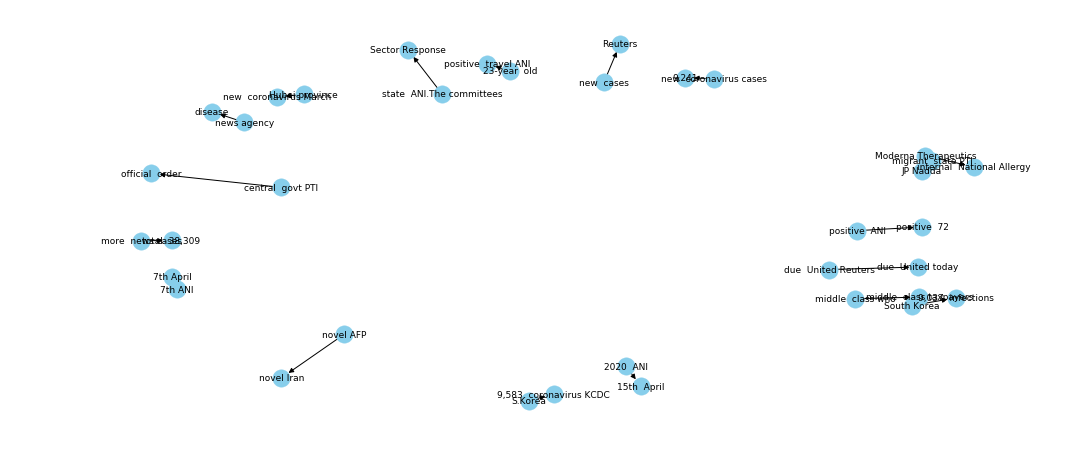

In [283]:
compute_and_plot_network(entities_and_relations_all,'reports')